## Import libraries

In [80]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
%matplotlib widget


In [81]:
plt.close("all")  # close all figure windows

## Initialization

### File selection and loading (REARM data)

In [82]:
# Define the xdf file path
FILENAME = "001_MolLud_20201112_1_c_499.txt"
# FILENAME="020_DesMar_20211129_1_c.xdf"
# path=os.path.normpath("../DAT/Input/001_MolLud_20201112_1_c.xdf")
path = os.path.normpath("DAT/INPUT/"+FILENAME)

In [83]:
EEG= np.loadtxt(path,dtype=float,delimiter=",")
EEG_raw_amplitudes=EEG[:,0:8]
EEG_times=EEG[:,8]
Srate=499
N=len(EEG_raw_amplitudes)

In [84]:
# definition of the EEG channels' names
channels_dic = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

### Electrode selection

In [85]:
# Selection of one electrode

ELECTRODE_NUMBER = 5  # [1,8]
ELECTRODE_INDEX = ELECTRODE_NUMBER-1  # python indices start a 0

print("electrode",str(ELECTRODE_NUMBER),"shape:",EEG_raw_amplitudes[:,ELECTRODE_INDEX].shape)

electrode 5 shape: (221938,)


### Signal centering

In [86]:
EEG_amplitudes_centered=EEG_raw_amplitudes-np.mean(EEG_raw_amplitudes,axis=0)

## Electrode C3

### Raw signal

(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


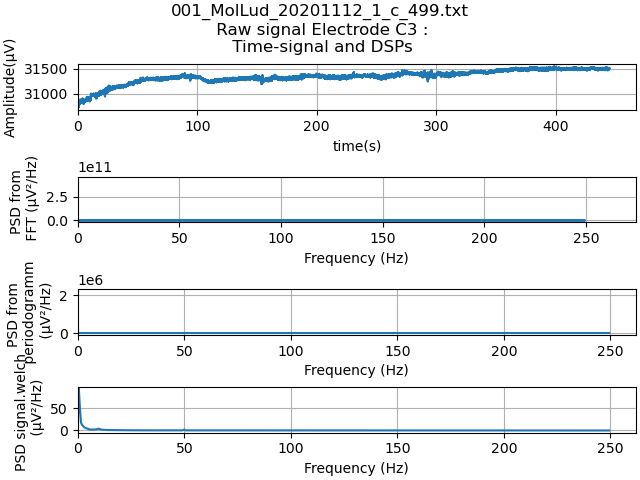

In [87]:
print(EEG_raw_amplitudes.shape)
plot_signal_time_dsps(EEG_raw_amplitudes[:,ELECTRODE_INDEX],sample_rate=Srate,signal_name=FILENAME+"\n Raw signal Electrode "+channels_dic["Channel_"+str(ELECTRODE_NUMBER)])

### Centered signal


(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


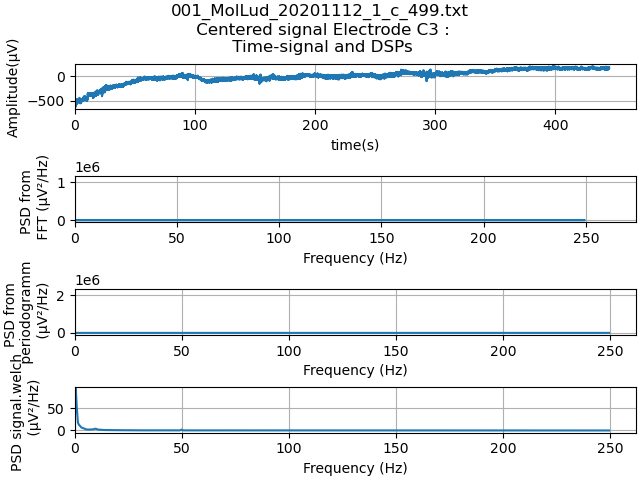

In [88]:
print(EEG_amplitudes_centered.shape)
plot_signal_time_dsps(EEG_amplitudes_centered[:,ELECTRODE_INDEX],sample_rate=Srate,signal_name=FILENAME+"\n Centered signal Electrode "+channels_dic["Channel_"+str(ELECTRODE_NUMBER)])

## Elecrode C4

In [89]:
# Selection of one electrode

ELECTRODE_NUMBER = 1  # [1,8]
ELECTRODE_INDEX = ELECTRODE_NUMBER-1  # python indices start a 0

print("electrode",str(ELECTRODE_NUMBER),"shape:",EEG_raw_amplitudes[:,ELECTRODE_INDEX].shape)

electrode 1 shape: (221938,)


### Raw signal

(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


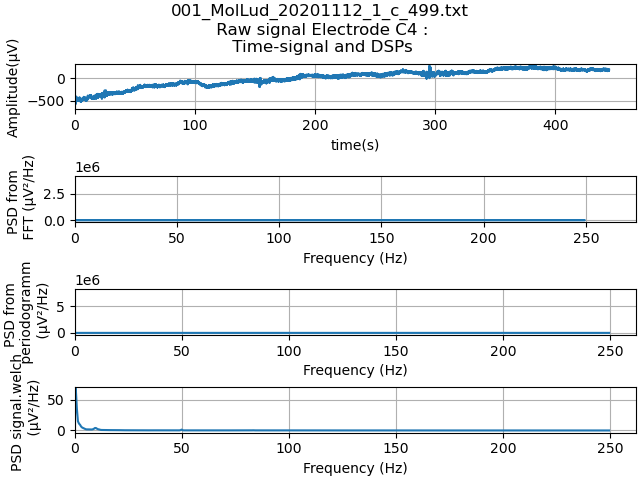

In [90]:
print(EEG_amplitudes_centered.shape)
plot_signal_time_dsps(EEG_amplitudes_centered[:,ELECTRODE_INDEX],sample_rate=Srate,signal_name=FILENAME+"\n Raw signal Electrode "+channels_dic["Channel_"+str(ELECTRODE_NUMBER)])

### Centered signal


(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


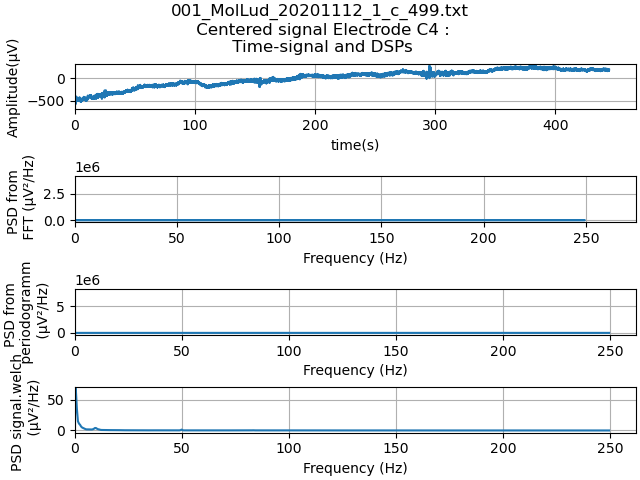

In [91]:
print(EEG_amplitudes_centered.shape)
plot_signal_time_dsps(EEG_amplitudes_centered[:,ELECTRODE_INDEX],sample_rate=Srate,signal_name=FILENAME+"\n Centered signal Electrode "+channels_dic["Channel_"+str(ELECTRODE_NUMBER)])